In [1]:
import workflow.scripts.RESources as RES
import pandas as pd
import geopandas as gpd

ModuleNotFoundError: No module named 'workflow.scripts.RESources'

In [ ]:
import workflow.scripts.RESources as RES
import pandas as pd
import geopandas as gpd

# Iterate over provinces for both solar and wind resources
resource_types = ['wind']  #,'solar'
provinces=['BC']  #,'AB','SK','ON','NS','MB'
for province_code in provinces:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "province_short_code": province_code,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

2025-04-23 09:06:01,827 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AB.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AB.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AB.h5 with key 'cost/atb/bess'


# Check the store if the results are ready

In [ ]:
from RES.hdf5_handler import DataHandler
import RES.visuals as vis
store=f"data/store/resources_{provinces[0]}.h5"
res_data=DataHandler(store)

In [ ]:
cells=res_data.from_store('cells')
boundary=res_data.from_store('boundary')
solar_clusters=res_data.from_store('clusters/solar')
wind_clusters=res_data.from_store('clusters/wind')
solar_clusters_ts=res_data.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_data.from_store('timeseries/clusters/wind')

In [ ]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW resource in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (DivisionNo.9_1) originally had 13.21 GW potential capacity.To fit the maximum capacity investment of 10 GW, it has been adjusted to 2.86 GW

>>> Selecting TOP Sites to for 20 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW resource in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (DivisionNo.4_2) originally had 10.69 GW potential capacity.To fit the maximum capacity investment of 20 GW, it has been adjusted to 7.15 

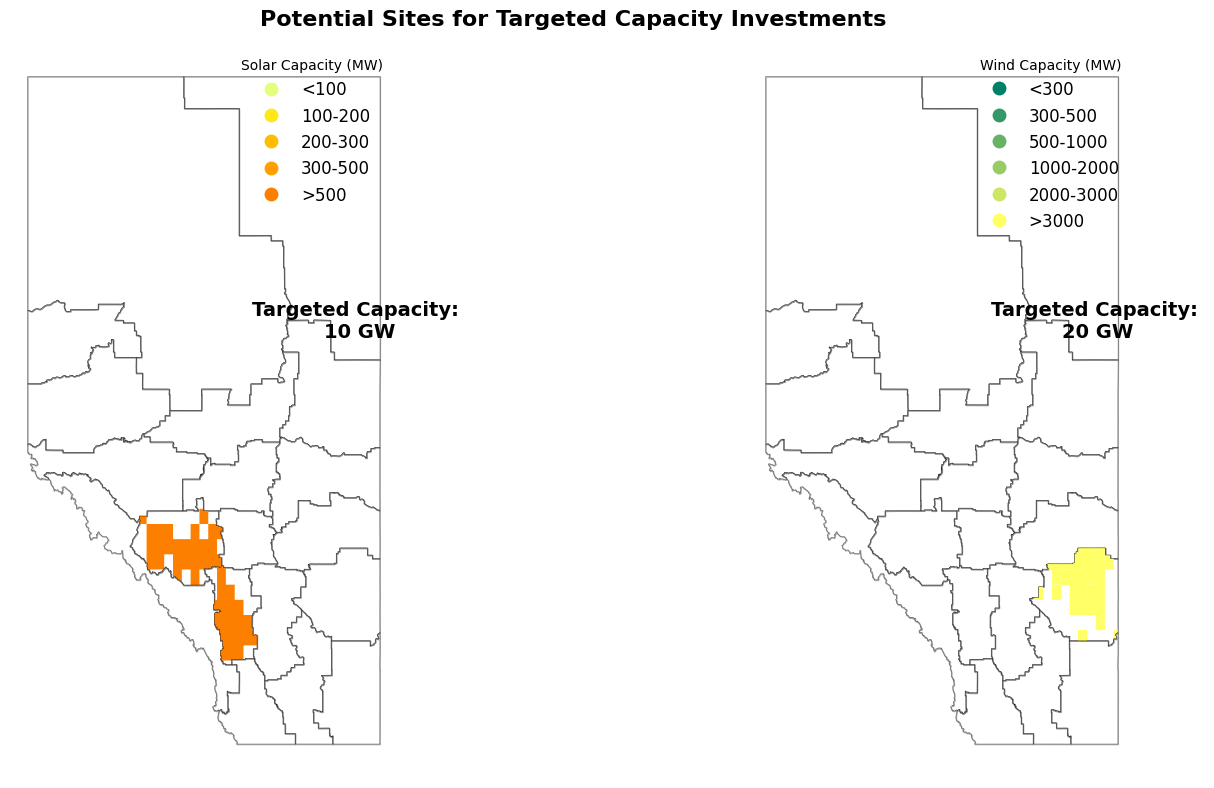

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

legend_x_ax_offset=1

# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()


# Add annotation for solar capacity
ax1.annotate(f"Targeted Capacity: \n{int(resource_clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(0.9, 0.6), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')

# Add annotation for wind capacity
ax2.annotate(f"Targeted Capacity: \n{int(resource_clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(0.9, 0.6), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')
# Show the side-by-side plot

plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()

In [ ]:
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

1635.4 MW


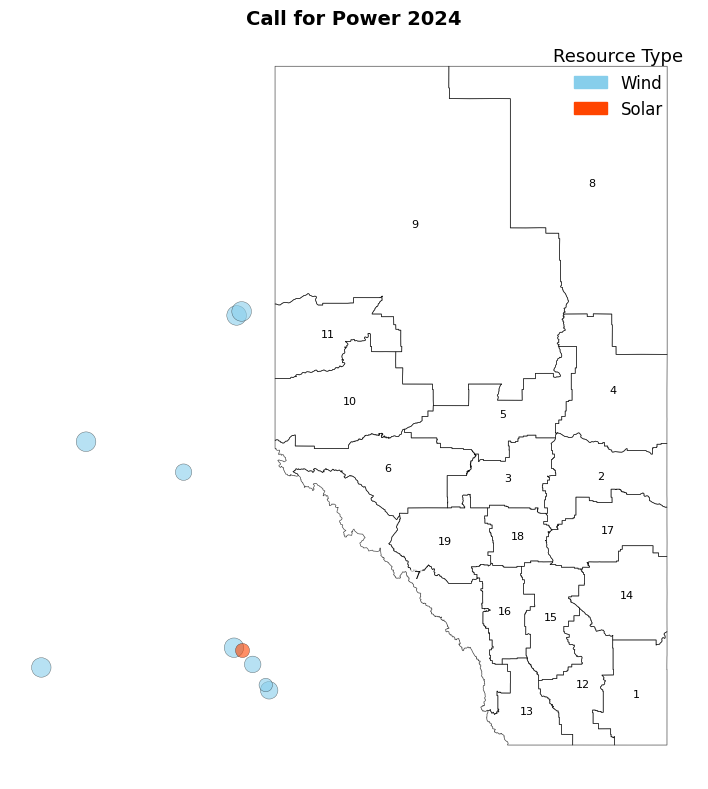

In [ ]:
CFP24=gpd.read_file('ROD_2024/BCH_CFP24.geojson')
print(f"{CFP24.potential_capacity.sum()} MW")

import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot boundaries
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.7, transform=ccrs.PlateCarree())

# Define color map manually
color_map = {'wind': 'skyblue', 'solar': 'orangered'}

# Plot each resource type separately for manual control
for resource, color in color_map.items():
    CFP24[CFP24['resource_type'] == resource].plot(
        ax=ax,
        markersize=CFP24[CFP24['resource_type'] == resource]['potential_capacity'],
        color=color,
        edgecolor='k',
        linewidth=0.3,
        alpha=0.6,
        transform=ccrs.PlateCarree()
    )

# Annotate region numbers
for _, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, f"{row['Region_Number']}",
            ha='center', va='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'),
            transform=ccrs.PlateCarree())

# Add clean basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ccrs.PlateCarree())

# Remove all borders and ticks
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Add custom legend
legend_elements = [
    mpatches.Patch(color='skyblue', label='Wind'),
    mpatches.Patch(color='orangered', label='Solar')
]
ax.legend(handles=legend_elements, title='Resource Type', fontsize=12, title_fontsize=13, loc='upper right', frameon=False)

# Set clean title
ax.set_title("Call for Power 2024", fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig('vis/misc/CFP24.png',dpi=600)

In [ ]:
# Load the data
elec_demand='''selection	region	scenario	year	value	unit	dataset
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2006	59275.791	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2009	60242.043	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2012	71623.218	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2015	71424.0277	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2022	69480.63812	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2025	72669.74578	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2028	75894.67904	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2031	88877.03508	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2035	95995.44909	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2038	103741.5152	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2010	60100.721	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2013	65157.5056	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2016	69609.4231	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2019	64333.814	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2026	73624.51074	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2029	80393.60758	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2032	92119.87512	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2039	106544.5794	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2042	115409.7581	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2045	124941.8985	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2048	134525.4109	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2005	65664.38	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2007	69444.68	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2014	66746.246	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2017	74089.1426	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2020	72029.63959	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2023	68914.107	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2030	84346.61932	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2033	95297.11161	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2036	98734.17747	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2043	118344.8613	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2046	128302.1161	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2049	137567.7422	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2005	65664.38	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2008	63722.706	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2011	68674.245	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2018	69235.603	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2021	71664.14946	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2024	68544.93829	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2027	74930.45612	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2034	98808.616	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2037	101306.3085	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2040	108914.6025	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2047	131414.1098	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2050	140535.5229	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2041	112546.5104	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CANADA NET-ZERO	2044	122012.3367	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2007	69444.68	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2014	66746.246	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2017	74089.1426	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2020	72029.63959	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2027	74106.7382	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2030	78827.14789	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2033	86395.54112	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2036	91401.70727	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2043	104506.326	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2046	110423.5666	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2049	116686.678	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2007	69444.68	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2010	60100.721	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2013	65157.5056	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2016	69609.4231	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2023	67905.55895	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2026	73805.58902	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2029	79448.88859	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2006	59275.791	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2009	60242.043	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2012	71623.218	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2015	71424.0277	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2022	69294.96197	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2025	72423.33708	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2028	74785.93617	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2035	89598.7052	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2038	95484.99029	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2041	101716.4014	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2044	106693.1114	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2005	65664.38	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2008	63722.706	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2015	71424.0277	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2018	69235.603	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2021	71664.14946	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2028	75637.04349	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2031	84843.23499	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2034	88143.67894	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2037	93240.239	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2008	63722.706	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2011	68674.245	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2018	69235.603	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2021	71664.14946	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2024	68497.30631	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2031	80946.24884	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2034	88177.92442	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2037	93499.60938	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2040	99526.85806	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2047	112440.621	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2050	119125.9488	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2011	68674.245	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2014	66746.246	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2017	74089.1426	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2020	72029.63959	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2024	67448.14469	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2027	74378.60682	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2030	81367.2863	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2033	85337.18522	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2040	103281.9867	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2036	89811.78063	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2039	100121.8502	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2042	108220.4955	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2045	114829.3728	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2044	113299.4396	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2047	120156.7013	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2050	131591.3452	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2043	110416.54	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2046	117076.9464	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2049	127448.8815	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2010	60100.721	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2013	65157.5056	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2016	69609.4231	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2019	64333.814	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2023	68848.46089	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2026	73384.78226	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2029	76965.87804	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2032	83877.61135	GW.h	2023
# ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2039	97928.33036	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2042	103146.367	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2045	108333.9304	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	CURRENT MEASURES	2048	114568.6573	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2006	59275.791	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2009	60242.043	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2012	71623.218	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2019	64333.814	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2022	68186.53229	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2025	73204.28801	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2032	83378.80551	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2035	86435.69762	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2038	96588.7449	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2041	106125.3583	GW.h	2023
ELECTRICITY GENERATION	BRITISH COLUMBIA	GLOBAL NET-ZERO	2048	123585.8601	GW.h	2023

...
'''

In [ ]:
# plt.figure(figsize=(12, 6))

# # Plot each scenario with specific styling
# for scenario in df['scenario'].unique():
#     if scenario == 'CURRENT MEASURES':
#         sns.lineplot(
#             data=df[df['scenario'] == scenario],
#             x='year',
#             y='value',
#             label=scenario,
#             color='k',
#             linewidth=5,  # Bold line
#             alpha=.8
#         )
#     else:
#         sns.lineplot(
#             data=df[df['scenario'] == scenario],
#             x='year',
#             y='value',
#             label=scenario,
#             linewidth=3,
#             alpha=0.8  # Transparent lines
#         )

# # Vertical line for current year
# plt.axvline(x=current_year, color='grey', linestyle='--', linewidth=1.5)
# plt.text(current_year + 0.5, plt.ylim()[1]*0.95, str(current_year), color='k')

# # Set axis label colors
# plt.ylabel('Electricity Generation (GWh)', color='grey')

# # Set tick label colors
# plt.tick_params(axis='x', colors='grey')
# plt.tick_params(axis='y', colors='grey')

# # Remove box and spines
# for spine in plt.gca().spines.values():
#     spine.set_visible(False)

# # Legend
# plt.legend(title='Canada Energy Future 2023, CER', title_fontsize=14, fontsize=11, loc='upper left', frameon=False)

# plt.title('Electricity Generation in British Columbia by Scenario', fontsize=16, weight='bold')
# plt.tight_layout()
# plt.savefig('CEF_BC_ELEC_DEMAND.png', dpi=600, transparent=True)


In [ ]:
import csv

# Create a dictionary mapping Region_Number to Region
region_mapping = {row['Region_Number']: row['Region'] for _, row in boundary.iterrows()}

# Export the mapping to a CSV file

with open('region_mapping.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Region_Number', 'Region'])
    for region_number, region_name in region_mapping.items():
        writer.writerow([region_number, region_name])

# Display the mapping outside of the plot
for region_number, region_name in region_mapping.items():
    print(f"{region_number}: {region_name}")


1: Division No. 1
2: Division No. 10
3: Division No. 11
4: Division No. 12
5: Division No. 13
6: Division No. 14
7: Division No. 15
8: Division No. 16
9: Division No. 17
10: Division No. 18
11: Division No. 19
12: Division No. 2
13: Division No. 3
14: Division No. 4
15: Division No. 5
16: Division No. 6
17: Division No. 7
18: Division No. 8
19: Division No. 9
